In [330]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, SpatialDropout1D, Input
from keras.layers import GlobalMaxPooling1D, GRU, SimpleRNN
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from pymongo import MongoClient
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import pymysql
import seaborn as sns
import datetime
import plotly.express as px

# CNN
from keras.layers.convolutional import Conv1D
# RNN
from keras.layers.recurrent import LSTM

In [331]:
scores_list = []
maxlen = 400
max_words= 225
n_df_size = 90000
model_name_for_sql = 'selfnn'
tosql = False
agg = [
    {
        '$sample': {
            'size': n_df_size
        }
    }
]

In [332]:
n_epochs = 4
n_nodes = 32
n_hidden_nodes = 128

In [333]:
client = MongoClient("localhost:27017")
db=client.indv
result=db.labeled.aggregate(agg)
source=list(result)
df=pd.DataFrame(source)
df.head()

,_id,level_0,index,Unnamed: 0,Review,Label,Total_Words
0,5ff492e0e042fba49719c55d,614701,614701,614701,Location is perfect close to metro station,Positive,7
1,5ff492e4e042fba49722149f,198319,198319,198319,Bathrooms are tiny poor drainage for the show...,Negative,18
2,5ff492e1e042fba4971cbdc2,610857,610857,610857,MiniBar is Free The decor is very warm inside,Positive,9
3,5ff492e0e042fba49719c8c8,704707,704707,704707,Staff was very friendly location the best,Positive,7
4,5ff492e6e042fba497246b33,209940,209940,209940,The private terrace and hot tub area could ha...,Negative,31


In [334]:
g = df.groupby('Label')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g

In [335]:
X = df['Review']
Y = df['Label']

In [336]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [337]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df['Review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [338]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [320]:
# SimpleRNN
model = Sequential()
model.add(Embedding(vocab_size,32,input_length=maxlen))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train,Y_train,batFch_size=32,epochs=n_epochs,validation_split=0.2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])
scores_list.append(scores)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 400, 32)           138336    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 128)               20608     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 159,073
Trainable params: 159,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
55/55 [==============================] - 18s 334ms/step - loss: 0.6825 - accuracy: 0.5547 - val_loss: 0.6591 - val_accuracy: 0.6736
Epoch 2/4
55/55 [==============================] - 17s 313ms/step - loss: 0.5596 - accuracy: 0.7368 - val_loss: 0.4752 - val_accuracy: 0.8276
Epoch 3/4
55/55 [==============================] - 18s 324ms/step - loss: 0.4654 - accuracy: 

In [321]:
# Convelutional 
# create the model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=maxlen))
    #  text is 1 dimensional, so Conv1D
    #  the kernel in this case is a vector of length 5, not a 2 dimensional matrix
model.add(Conv1D(128, 5, activation='relu'))
    #  the pooling layer in this case is also 1 dimensional
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, Y_train, batch_size=32, epochs=n_epochs, verbose=1, validation_split=0.2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])
scores_list.append(scores)

Epoch 1/4
55/55 [==============================] - 4s 71ms/step - loss: 0.6461 - accuracy: 0.7609 - val_loss: 0.5177 - val_accuracy: 0.8851
Epoch 2/4
55/55 [==============================] - 4s 70ms/step - loss: 0.3399 - accuracy: 0.9101 - val_loss: 0.2593 - val_accuracy: 0.9011
Epoch 3/4
55/55 [==============================] - 4s 69ms/step - loss: 0.2111 - accuracy: 0.9245 - val_loss: 0.2434 - val_accuracy: 0.8943
Epoch 4/4
17/17 [==============================] - 0s 21ms/step - loss: 0.2450 - accuracy: 0.9042
Test Score: 0.2449549287557602
Test Accuracy: 0.9042357206344604


In [322]:
# LSTM
model = Sequential()
model.add(Embedding(vocab_size,32,input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train,Y_train,batch_size=32,epochs=n_epochs,validation_split=0.2)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])
scores_list.append(scores)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 400, 32)           138336    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 220,897
Trainable params: 220,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
55/55 [==============================] - 30s 550ms/step - loss: 0.6248 - accuracy: 0.6763 - val_loss: 0.4957 - val_accuracy: 0.8069
Epoch 2/4
55/55 [==============================] - 30s 554ms/step - loss: 0.3609 - accuracy: 0.8669 - val_loss: 0.3004 - val_accuracy: 0.8966
Epoch 3/4
55/55 [==============================] - 40s 720ms/step - loss: 0.2684 - accuracy: 

In [323]:
# eigen model
model = Sequential()
# input layer
model.add(Embedding(vocab_size, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X_train, Y_train, batch_size=128, epochs=n_epochs, verbose=1, validation_split=0.2)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=1)
print("Test Score:", scores[0])
print("Test Accuracy:", scores[1])
scores_list.append(scores)

Epoch 1/4
14/14 [==============================] - 1s 55ms/step - loss: 0.7004 - accuracy: 0.5207 - val_loss: 0.6832 - val_accuracy: 0.5724
Epoch 2/4
14/14 [==============================] - 1s 64ms/step - loss: 0.6705 - accuracy: 0.6440 - val_loss: 0.6499 - val_accuracy: 0.7862
Epoch 3/4
14/14 [==============================] - 1s 56ms/step - loss: 0.6093 - accuracy: 0.8007 - val_loss: 0.5601 - val_accuracy: 0.8575
Epoch 4/4
17/17 [==============================] - 0s 8ms/step - loss: 0.4294 - accuracy: 0.8471
Test Score: 0.42936182022094727
Test Accuracy: 0.8471454977989197


In [324]:
scoredDf = pd.DataFrame(scores_list)

In [325]:
scoredDf['model'] = 'nan'

In [326]:
scoredDf['model'][0:1] = 'SimpleRnn'
scoredDf['model'][1:2] = 'Convolutional'
scoredDf['model'][2:3] = 'LSTM'
scoredDf['model'][3:4] = 'eign'

In [327]:
scoredDf.columns = ['loss', 'accuracy', 'model']

<AxesSubplot:xlabel='model'>

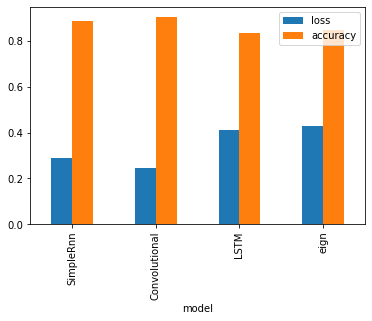

In [328]:
scoredDf.plot.bar(x='model')

In [329]:
# px.bar(scoredDf,x='model', y=['acc', 'score'], barmode='group')

ValueError: All arguments should have the same length. The length of argument `y` is 2, whereas the length of  previously-processed arguments ['model'] is 4